# Project: Electricity Demand forecasting

## Summary  
__Aim: We need to forecast the next 24 months' demand__  

- Step-1. EDA (there are no nulls :))   
1. Data has an increasing trend (Figure-1)  
2. Monthly data is given to us (Figure-2)  
3. DF test: model is not stationary (EDA table-1)  
4. Multiplicative decomposition works best and decomposes into trend, seasonality and residuals (Figure-3 and Figure-4)  
5. Autocorrelation function (ACF, Figure-5) shows seasonality and tells us that after a lag of 2 years data has an insignificant effect on present.  
6. Partial Autocorrelation function (PACF, Figure-6) also highlights seasonality  

Step-2: Modeling  
__How I see it is that__
- I will use data(-24 months) to fit and predict the last 24 months for which we do have data.  
- Then with the best model, I will create a new fit with all given data using the parameters that best predicted the last 24 months

7. ExponentialSmoothing
8. SARIMA using guestimate based on EDA
9. auto_SARIMA to automatically identify parameters (_hint: best performance_; Figure-7)
10. Prophet by Facebook, worthy competitor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Results first ;)

In [2]:
pd.read_csv("tmp/model_eval.csv")

,model,rmse,rmspe,mape
0,ETS,5.767906,0.059062,5.152836
1,FBProphet,5.310779,0.051901,4.525261
2,SARIMA guess,4.184353,NaN,NaN
3,auto_SARIMA,3.247649,0.032986,2.528452


_Result: SARIMA is our best bet in determining future demand. With Prophet being a close contender_

## Exploratory Data Analysis
-import
-basic plots

In [3]:
elec_df = pd.read_csv(f"data/Electricity Consumption.csv")
elec_df['date'] = pd.to_datetime(elec_df['DATE'])
elec_df.head()

,DATE,Electricty_Consumption_in_TW,date
0,1/1/1973,35.9728,1973-01-01
1,2/1/1973,36.1334,1973-02-01
2,3/1/1973,35.0625,1973-03-01
3,4/1/1973,33.8416,1973-04-01
4,5/1/1973,33.5107,1973-05-01


In [4]:
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DATE                          561 non-null    object        
 1   Electricty_Consumption_in_TW  561 non-null    float64       
 2   date                          561 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 13.3+ KB


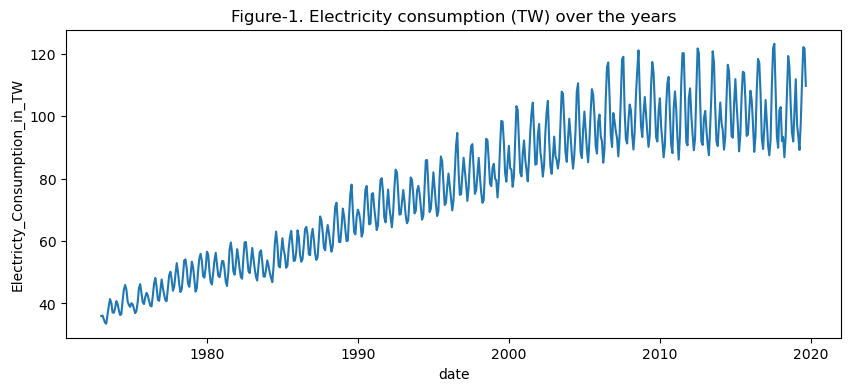

In [5]:
plt.figure(figsize=(10,4))
sns.lineplot(x='date', y='Electricty_Consumption_in_TW', data=elec_df)
plt.title('Figure-1. Electricity consumption (TW) over the years')
plt.savefig('pngs/Fig1_Electricity_consumption_TW_over_the_years.png')

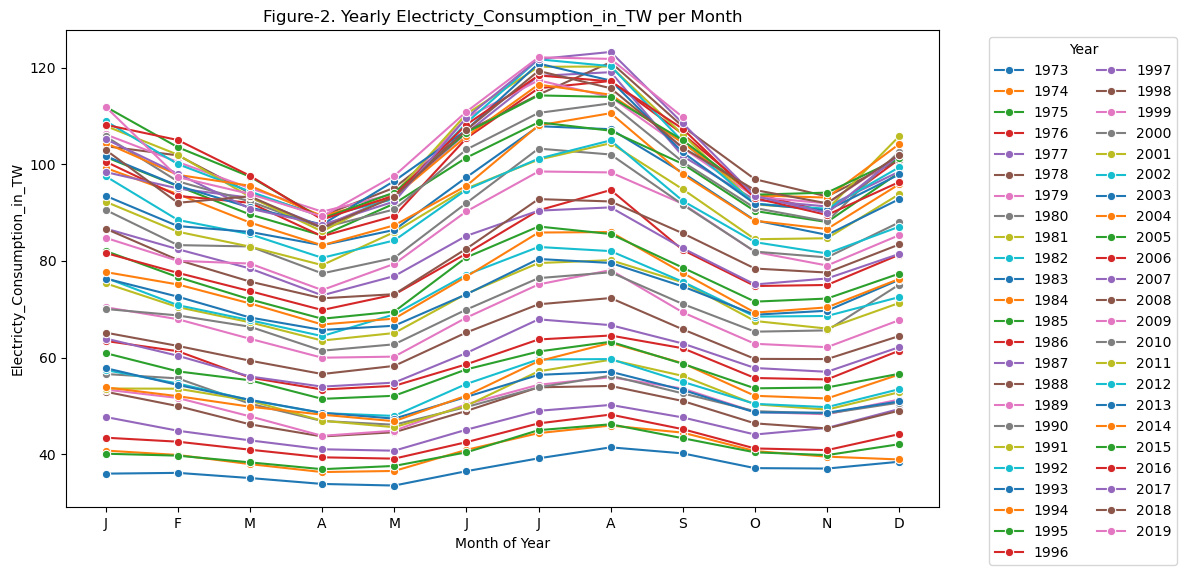

In [6]:
elec_df['year'] = elec_df['date'].dt.year
elec_df['DayOfYear'] = elec_df['date'].dt.dayofyear
elec_df['month'] = elec_df['date'].dt.month
month_map = {1: 'J', 2: 'F', 3: 'M', 4: 'A', 5: 'M', 6: 'J', 7: 'J', 8: 'A', 9: 'S', 10: 'O', 11: 'N', 12: 'D'}
elec_df['MonthAbbrev'] = elec_df['month'].map(month_map)

plt.figure(figsize=(12, 6))
palette = sns.color_palette("tab10", n_colors=elec_df['year'].nunique())
sns.lineplot(data=elec_df, x='month', y='Electricty_Consumption_in_TW', hue='year', marker='o', palette=palette)

# Add titles and labels
plt.xticks(ticks=np.arange(1, 13), labels=[month_map[i] for i in range(1, 13)])
plt.title('Figure-2. Yearly Electricty_Consumption_in_TW per Month')
plt.xlabel('Month of Year')
plt.ylabel('Electricty_Consumption_in_TW')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.savefig('pngs/Fig2_Yearly_Electricty_Consumption_in_TWperMonth.png')
plt.show()

#### conditions of noise
- constant mean
- constant variance
- no autocorrelation

### Stationarity 
- taking consecutive spans of data with same length should have identical covariance [Covariance(span1) = Covariance(span2)]
- Covaraince = Correlation() * std1 * std2 = 0 ## not strictly math version

#### Dickey-Fuller Test (DF test)
- Is data stationary?
- Hypothesis data is not stationary.

In [7]:
import statsmodels.tsa.stattools as sts

In [8]:
print('EDA table-1: data is not stationary')
sts.adfuller(elec_df.Electricty_Consumption_in_TW)
## test statistic
## p-value (0.41) - 41% chance of not rejecting the null so we can't be sure
## df = 15, autocorrelation going back 15 periods, the significant lag period
## 545 - number of observations used in analysis, lags used
## 1% 5% and 10% significance values -- no evidence of stationarity
## 2295 - maximized information criteria, lower the value easier the correlation. ##?

EDA table-1: data is not stationary


(-1.740593372983267,
 0.4103281604468564,
 15,
 545,
 {'1%': -3.442405720052601,
  '5%': -2.866857804790472,
  '10%': -2.5696022094099824},
 2295.409663118043)

__The P-Value is very weak, we cannot reject the null hypothesis that– the series is not stationary__  
__Therefore, the series is not stationary!!!__

### Decomposition of a time series into-
- Trend  
- Seasonality  
- Residual (prediction errors)  
#### "Naive" Decomposition  
- Additive    
observed = trend + seasonal + residual  
- Multiplicative    
observed = trend * seasonal * residual  

#### Decompose the time series by separating the seasonal component, trend and residuals 

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

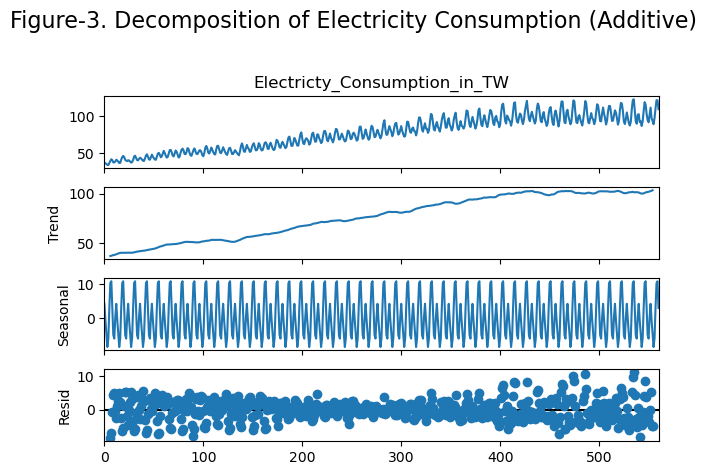

In [10]:
decomposed_additive = seasonal_decompose(elec_df['Electricty_Consumption_in_TW'], model='additive', period=12)
fig = decomposed_additive.plot()
fig.suptitle('Figure-3. Decomposition of Electricity Consumption (Additive)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.savefig('pngs/Fig3_DecompositionElectricity_additive.png')
plt.show()

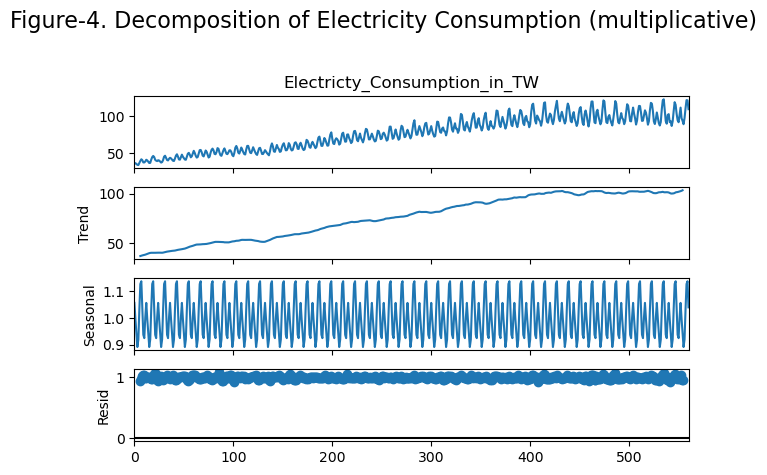

In [11]:
decomposed_multiplicative = seasonal_decompose(elec_df['Electricty_Consumption_in_TW'], model='multiplicative', period=12)
fig2 = decomposed_multiplicative.plot()
fig2.suptitle('Figure-4. Decomposition of Electricity Consumption (multiplicative)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.savefig('pngs/Fig3_DecompositionElectricity_multiplicative.png')
plt.show()

#### Is it additive or multiplicative?
- [resource for whether it is additive or multiplicative.](https://online.stat.psu.edu/stat510/lesson/5/5.1)
- I believe it is multiplicative as __residuals fluctuate around 1 in multiplicative__ suggesting that the multiplicative model captures the seasonal fluctuations well. In the multiplicative model, the residuals are expressed as a ratio, so a fluctuation around 1 implies that the seasonal component is proportional to the level of the time series.
- Usually, we would consider the seasonal part more but in both analyses the seasonal component is within the same range from begining to end.
__It is additive__


### The Auto correlation function (ACF)

In [12]:
import statsmodels.graphics.tsaplots as sgt

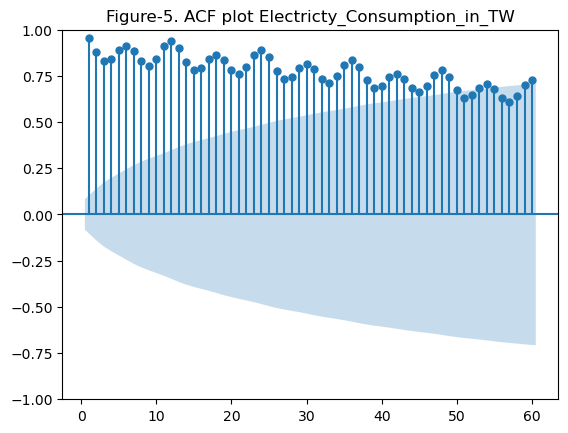

In [13]:
sgt.plot_acf(elec_df['Electricty_Consumption_in_TW'], lags = 60, zero=False)
## lags = 40 is common practice
## zero = False, no correlation report for a num to itself
plt.title("Figure-5. ACF plot Electricty_Consumption_in_TW")
plt.savefig("pngs/Fig5_ACF.png")

#### The ACF plot
- lag is plotted on the x axis
- the translucent area is area of no significance
- the dots outside the translucent are significant. 
- dots are the measures of correlation
- so I guess lag after 24 months it is becoming pointless to carry on the analysis
- and at 60 it is insignificant
- The ACF plot measures the influence of X point and all the other points between X and target. So if we are looking for effect of 10th interval, it is actually effect of 1-10 intervals.
- Look also at the seasonality in the data, we definitely need SARIMAX (below) 

### Partial Auto-correlation coefficient (PACF)

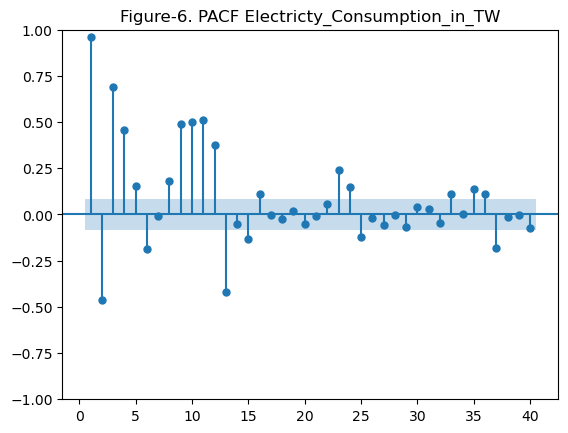

In [14]:
sgt.plot_pacf(elec_df.Electricty_Consumption_in_TW, lags=40, zero=False, method=('ols'))
plt.title("Figure-6. PACF Electricty_Consumption_in_TW")
## PACF only shows the direct effect, while ACF shows direct and indirect effect through interstitial values.
## some insights
### negative points at 2,6, and 13 have negative effect on current data
### while 1,3,4 have positive effect
plt.savefig("pngs/Fig6_PACF.png")

- In PACF each auto-regressor is assessed independently for correlation without regard to intermediate regressors

## Modeling
- Coeffs need to be significantly different from 0
- Parsimounious model (prefer simpler model)
- Log likelyhood ratio to score differences in models (use lower AIC and BIC)
- Residuals should be white noise, and not have any trend

In [15]:
## function for error determination
from sklearn.metrics import mean_squared_error
def get_errs(actual_future, forecast_values, mod):
    rmse = np.sqrt(mean_squared_error(actual_future, forecast_values))
    rmspe = np.sqrt(np.mean(((actual_future - forecast_values) / actual_future) ** 2))
    mape = np.mean(np.abs((actual_future - forecast_values) / actual_future)) * 100
    res = pd.DataFrame({'metric':['rmse','rmspe','mape'], 'value':[rmse, rmspe, mape], 'model':[mod, mod, mod]})
    print(f"table for evaluating {mod}:")
    return res

### ExponentialSmoothing

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_ets = ExponentialSmoothing(elec_df['Electricty_Consumption_in_TW'][:-24], trend='add', seasonal='add', seasonal_periods=12)
ets_fit = model_ets.fit()

# Make predictions for the next 24 months (2 years)
ets_forecast = ets_fit.forecast(steps=24)
elec_df['Electricty_Consumption_in_TW'][-24:], ets_forecast
errs_ETS = get_errs(elec_df['Electricty_Consumption_in_TW'][-24:], ets_forecast, 'ETS')
errs_ETS

table for evaluating ETS:


,metric,value,model
0,rmse,5.767906,ETS
1,rmspe,0.059062,ETS
2,mape,5.152836,ETS


In [17]:
## from statsmodels.tsa.ar_model import ARIMA

#### Model Selection 
##### Simple auto regressive model (ARMA model)
- statsmodels.tsa.arima_model.ARMA
- only non-seasonal parameters (p, q)
- integration order (d)

##### Higher Lag AR Models
- add more lag
- p-value > 0.05 the other lags are not significantly greater than 0, so there is no need of these (e.g., t-1, t-2 etc)

_model.summary()_
_models with higher log-likelihood and lower AIC, informational criterion._
_AR models are for stationary data. But our plots and Dickey-Fuller test implies that our data is not stationary. So, moving on_

_So we need to transform our dat_
_In finance we can transform by looking at stock returns as opposed to stock price_
#### ARIMA model accounts for integrations
- statsmodels.tsa.arima_model.ARMA
- only non-seasonal parameters (p, q)
- integration order (d)
- d does not change the number of coefficients.

_NB: missing values cause the ACF to fail. therefore pass the series[1:]_

_In other words ARIMA(p,d,q) model is an ARMA(p,q) model for a newly generated time series that requires 1,2, or more integrations as d. what are these new series? these are derived series like the stock returns from stock price_   

__But, ARIMA does not account for seasonality which is present in our data__  

#### ARIMAX - an extra variable - X 
- X is a new variable in the dataset that can help explain the data better
- All dates should have a value for variable X

__We do not have any exogenous variable in our data which has only two columns._

### SARIMAX: Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors Model
_Well we dont have an X so we will use a SARIMA model without the X_  
- the SARIMAX equation is -

$$
\begin{aligned}
    y_t & = \mu + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} \\
        & \quad - \theta_1 \epsilon_{t-1} - \theta_2 \epsilon_{t-2} - \dots - \theta_q \epsilon_{t-q} \\
        & \quad + \Phi_1 y_{t-s} + \Phi_2 y_{t-2s} + \dots + \Phi_P y_{t-Ps} \\
        & \quad - \Theta_1 \epsilon_{t-s} - \Theta_2 \epsilon_{t-2s} - \dots - \Theta_Q \epsilon_{t-Qs} \\
        & \quad + \beta_1 x_{1t} + \beta_2 x_{2t} + \dots + \beta_k x_{kt} + \epsilon_t
\end{aligned}
$$

**Where:**
- $y_t$ is the value of the time series at time $t$.
- $\mu$ is the intercept.
- $\phi_i$ are the parameters of the non-seasonal autoregressive (AR) terms.
- $\theta_i$ are the parameters of the non-seasonal moving average (MA) terms.
- $\Phi_i$ are the parameters of the seasonal autoregressive (SAR) terms.
- $\Theta_i$ are the parameters of the seasonal moving average (SMA) terms.
- $s$ is the length of the seasonal cycle.
- $\beta_i$ are the coefficients of the exogenous variables $x_{it}$.
- $\epsilon_t$ is the error term (white noise).

##### Simplified Notation

The SARIMAX model can also be summarized using the notation $(p,d,q) \times (P,D,Q)_s$ with exogenous regressors, where:
- $p$ is the order of the non-seasonal AR terms.
- $d$ is the order of non-seasonal differencing.
- $q$ is the order of the non-seasonal MA terms.
- $P$ is the order of the seasonal AR terms.
- $D$ is the order of seasonal differencing.
- $Q$ is the order of the seasonal MA terms.
- $s$ is the length of the seasonal cycle.

##### Example

For example, a SARIMAX model with \( p=1 \), \( d=1 \), \( q=1 \), \( P=1 \), \( D=1 \), \( Q=1 \), and \( s=12 \) with exogenous regressors would be written as:

$$
\text{SARIMAX}(1,1,1) \times (1,1,1)_{12} \text{ with exogenous regressors}
$$

This representation helps in understanding and communicating the structure of the model clearly.


#### SARIMA: employed with an educated guess
We will use SARIMA model that supports univariate time series data with a seasonal component. The SARIMA model includes both non-seasonal and seasonal factors, and it's often denoted as SARIMA(p,d,q)(P,D,Q,s), where:  

(p,d,q) are the non-seasonal parameters:  
_lowercase is used for non-seasonal parameters_  
p: The number of lag observations included in the model (autoregressive terms).  
d: The number of times that the raw observations are differenced (differencing order).  
q: The size of the moving average window (moving average terms).  
(P,D,Q,s) are the seasonal parameters:  
  
(P,D,Q,s) are seasonal parameters:  
P: The number of seasonal autoregressive terms.  
D: The number of seasonal differences.  
Q: The number of seasonal moving average terms.  
s: The number of observations per season (e.g., 12 for monthly data with an annual seasonal cycle).  

##### lets discuss s  
- if s=1: there is no seasonality   
- for 1 year in months, we will set it to 12   
- So for SARIMAX(1,0,2)(2,0,1,12) the number of coefficients = P + Q + p + q = 6 
- 1 (non-seasonal AR) + 2 (non-seasonal MA) + 2 (seasonal AR) + 1 (seasonal MA) + 1 (intercept) = 7 

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [19]:
model_SARIMAX = SARIMAX(elec_df.Electricty_Consumption_in_TW, order=(1,0,1), seasonal_order = (2,0,1,12))
results_SARIMAX = model_SARIMAX.fit()
results_SARIMAX.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32531D+00    |proj g|=  1.63484D+00

At iterate    5    f=  2.25865D+00    |proj g|=  7.75001D-02


 This problem is unconstrained.



At iterate   10    f=  2.16109D+00    |proj g|=  4.53188D-02

At iterate   15    f=  2.11902D+00    |proj g|=  1.64595D-02

At iterate   20    f=  2.11322D+00    |proj g|=  2.20492D-03

At iterate   25    f=  2.11302D+00    |proj g|=  1.19749D-02

At iterate   30    f=  2.10552D+00    |proj g|=  7.66138D-03

At iterate   35    f=  2.10540D+00    |proj g|=  1.02142D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     51      1     0     0   5.333D-06   2.105D+00
  F =   2.1054021733540407     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:       Electricty_Consumption_in_TW   No. Observations:                  561
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood               -1181.131
Date:                            Tue, 06 Aug 2024   AIC                           2374.261
Time:                                    17:01:38   BIC                           2400.240
Sample:                                         0   HQIC                          2384.404
                                            - 561                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9614      0.014     70.441      0.000       0.935       0.988
ma.L1         -0.1754      0.040     -4.441      0.000      -0.253      -0.098
ar.S.L12       1.0396      0.062     16.842      0.000       0.919       1.161
ar.S.L24      -0.0429      0.061     -0.708      0.479      -0.162       0.076
ma.S.L12      -0.6811      0.055    -12.433      0.000      -0.789      -0.574
sigma2         3.6515      0.190     19.265      0.000       3.280       4.023
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                25.17
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               4.69   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
## The only way I see to get Error estimates here is to train the model on data sans last 24 months and then predict the last 24 months and get RMSE, RMSPE and MAPE
model_SARIMAX_guess = SARIMAX(elec_df.Electricty_Consumption_in_TW, order=(1,0,1), seasonal_order = (2,0,1,12))
SARIMAX_fit_guess = model_SARIMAX_guess.fit(disp=False)
SARIMAX_forecast_guess = SARIMAX_fit_guess.get_forecast(steps=24).predicted_mean

errs_SARIMAX_guess = get_errs(elec_df['Electricty_Consumption_in_TW'][-24:], SARIMAX_forecast_guess, 'SARIMA guess')
errs_SARIMAX_guess

table for evaluating SARIMA guess:


,metric,value,model
0,rmse,4.184353,SARIMA guess
1,rmspe,NaN,SARIMA guess
2,mape,NaN,SARIMA guess


### SARIMAX auto training
- kind-of-Gridsearch for optimal SARIMA parameters
- Selection of parameters that result in the lowest RMSE

In [21]:
from pmdarima.arima import auto_arima

In [22]:
model_auto = auto_arima(elec_df.Electricty_Consumption_in_TW[1:], 
                        m = 12,
                       max_order = None, max_p = 7, max_q = 7, max_d = 2, 
                       max_P = 4, max_Q = 4, max_D = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob',
                       out_of_sample = int(len(elec_df)*0.2))

In [23]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  560
Model:             SARIMAX(1, 1, 2)x(3, 0, [], 12)   Log Likelihood               -1164.661
Date:                             Tue, 06 Aug 2024   AIC                           2347.322
Time:                                     17:04:13   BIC                           2386.257
Sample:                                          0   HQIC                          2362.526
                                             - 560                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0103      0.040      0.256      0.798      -0.069       0.089
drift      -5.411e-06      0.000     -0.049      0.961      -0.000       0.000
ar.L1          0.1996      0.097      2.054      0.040       0.009       0.390
ma.L1         -0.4302      0.096     -4.472      0.000      -0.619      -0.242
ma.L2         -0.2974      0.053     -5.589      0.000      -0.402      -0.193
ar.S.L12       0.4727      0.033     14.395      0.000       0.408       0.537
ar.S.L24       0.1472      0.041      3.569      0.000       0.066       0.228
ar.S.L36       0.3429      0.038      9.058      0.000       0.269       0.417
sigma2         3.6496      0.176     20.794      0.000       3.306       3.994
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                48.70
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.37   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
## drift indicates linear trend coefficient
## so the model is - SARIMAX(1, 1, 2)x(3, 0, [], 12)

In [25]:
## The only way I see to get Error estimates here is to train the model on data sans last 24 months and then predict the last 24 months and get RMSE, RMSPE and MAPE
model_SARIMAX_auto = SARIMAX(elec_df['Electricty_Consumption_in_TW'][:-24], order=(1,1,2), seasonal_order=(3,0,[],12))
SARIMAX_fit = model_SARIMAX_auto.fit(disp=False)
SARIMAX_forecast = SARIMAX_fit.get_forecast(steps=24).predicted_mean

errs_autoARIMA = get_errs(elec_df['Electricty_Consumption_in_TW'][-24:], SARIMAX_forecast, 'auto_SARIMA')
errs_autoARIMA

table for evaluating auto_SARIMA:


,metric,value,model
0,rmse,3.247649,auto_SARIMA
1,rmspe,0.032986,auto_SARIMA
2,mape,2.528452,auto_SARIMA


#### The best model is model_SARIMAX_auto
- need to train it on all data

#### Now that we know it is the best model we need to train SARIMAX_auto on all data available for help with forecasting

In [26]:
model_SARIMAX_auto_allData = SARIMAX(elec_df['Electricty_Consumption_in_TW'], order=(1,1,2), seasonal_order=(3,0,[],12))
SARIMAX_fit_allData = model_SARIMAX_auto_allData.fit(disp=False)
SARIMAX_forecast_allData = SARIMAX_fit_allData.get_forecast(steps=24).predicted_mean

In [27]:
elec_df.tail()

,DATE,Electricty_Consumption_in_TW,date,year,DayOfYear,month,MonthAbbrev
556,5/1/2019,97.5860,2019-05-01,2019,121,5,M
557,6/1/2019,110.8580,2019-06-01,2019,152,6,J
558,7/1/2019,122.1014,2019-07-01,2019,182,7,J
559,8/1/2019,121.7765,2019-08-01,2019,213,8,A
560,9/1/2019,109.7190,2019-09-01,2019,244,9,S


In [28]:
start_date = pd.to_datetime('2019-09-01')
next_month_start = start_date + pd.DateOffset(months=1)
date_range = pd.date_range(start=start_date, periods=24, freq='M')
forecast_df = pd.DataFrame({'date': date_range})
forecast_df['Month'] = date_range.month
forecast_df['Year'] = date_range.year
forecast_df.head()

,date,Month,Year
0,2019-09-30,9,2019
1,2019-10-31,10,2019
2,2019-11-30,11,2019
3,2019-12-31,12,2019
4,2020-01-31,1,2020


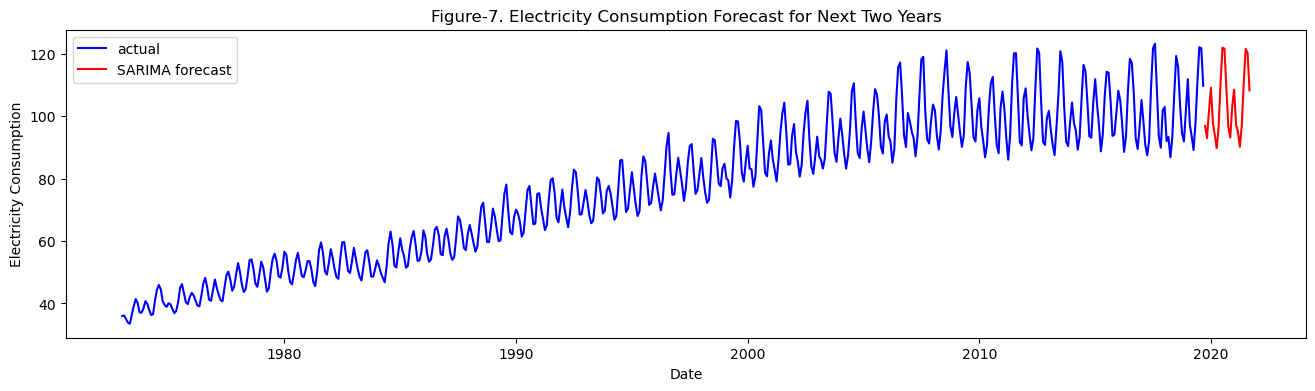

In [29]:
# Plot of the forecast with known for perspective
forecast_df['SARIMAX_forecast_allData'] = SARIMAX_forecast_allData.values
plt.figure(figsize=(16, 4))
sns.lineplot(x='date', y='Electricty_Consumption_in_TW', data=elec_df, color='blue', label='actual')
sns.lineplot(x='date', y='SARIMAX_forecast_allData', data=forecast_df, color='red', label='SARIMA forecast')
plt.title('Figure-7. Electricity Consumption Forecast for Next Two Years')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.savefig("pngs/Fig7_Electricity_Consumption.png")
plt.show()


### PROPHET: Time for the magical Prophet by Facebook which among other things takes care of Holidays!

In [30]:
import prophet

In [31]:
elec_df.head()

,DATE,Electricty_Consumption_in_TW,date,year,DayOfYear,month,MonthAbbrev
0,1/1/1973,35.9728,1973-01-01,1973,1,1,J
1,2/1/1973,36.1334,1973-02-01,1973,32,2,F
2,3/1/1973,35.0625,1973-03-01,1973,60,3,M
3,4/1/1973,33.8416,1973-04-01,1973,91,4,A
4,5/1/1973,33.5107,1973-05-01,1973,121,5,M


In [32]:
elec_fb = elec_df[['date', 'Electricty_Consumption_in_TW']]
elec_fb.rename(columns={'date':'ds','Electricty_Consumption_in_TW':'y'}, inplace=True)
elec_fb.head()

,ds,y
0,1973-01-01,35.9728
1,1973-02-01,36.1334
2,1973-03-01,35.0625
3,1973-04-01,33.8416
4,1973-05-01,33.5107


In [33]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


In [34]:
m_prophet = Prophet(interval_width=0.95, yearly_seasonality=True)
m_prophet.fit(elec_fb[:-24])

17:04:17 - cmdstanpy - INFO - Chain [1] start processing
17:04:17 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
future = m_prophet.make_future_dataframe(periods=24, freq='M')
future.tail()

,ds
556,2019-04-30
557,2019-05-31
558,2019-06-30
559,2019-07-31
560,2019-08-31


In [36]:
forecast = m_prophet.predict(future)

In [37]:
errs_prophet = get_errs(elec_fb['y'][-24:], forecast['yhat'][-24:], 'FBProphet')
errs_prophet

table for evaluating FBProphet:


,metric,value,model
0,rmse,5.310779,FBProphet
1,rmspe,0.051901,FBProphet
2,mape,4.525261,FBProphet


#### Now that we know it is a useful model we need to train Prophet on all data available for help with forecasting

17:04:17 - cmdstanpy - INFO - Chain [1] start processing
17:04:17 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Figure-8. Prophetic components')

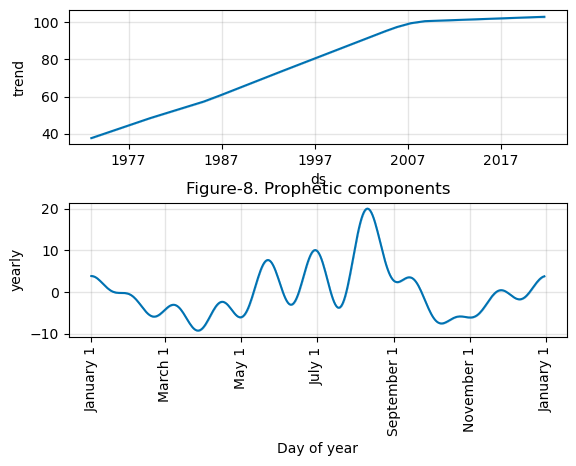

In [38]:
## Now train on all data
m_prophet_all = Prophet(interval_width=0.95)
m_prophet_all.fit(elec_fb)
future_assignment = m_prophet_all.make_future_dataframe(periods=24, freq='M')
forecast_assignment = m_prophet_all.predict(future_assignment)
m_prophet.plot_components(forecast_assignment, uncertainty=True, figsize=(6,4))
plt.xticks(rotation=90);
plt.title("Figure-8. Prophetic components")

Text(0.5, 1.0, 'Figure-8. Prophetic prediction output')

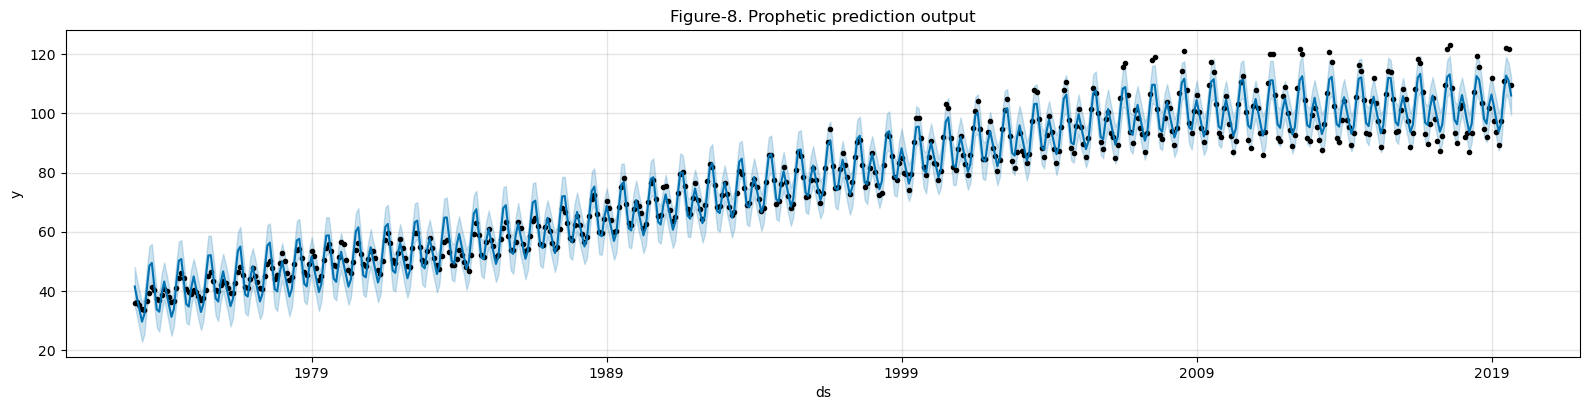

In [39]:
m_prophet_all.plot(forecast, uncertainty=True, figsize=(16, 4));
plt.title("Figure-8. Prophetic prediction output")

In [40]:
forecast_assignment.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
580,2021-04-30,102.927914,90.499555,103.329628,102.641611,103.203599,-6.224643,-6.224643,-6.224643,-6.224643,-6.224643,-6.224643,0.0,0.0,0.0,96.703271
581,2021-05-31,102.943543,100.081198,113.228658,102.636136,103.239243,3.751062,3.751062,3.751062,3.751062,3.751062,3.751062,0.0,0.0,0.0,106.694605
582,2021-06-30,102.958668,106.923821,120.563579,102.626427,103.279055,10.891977,10.891977,10.891977,10.891977,10.891977,10.891977,0.0,0.0,0.0,113.850645
583,2021-07-31,102.974297,106.273201,119.306726,102.618562,103.313137,9.719445,9.719445,9.719445,9.719445,9.719445,9.719445,0.0,0.0,0.0,112.693742
584,2021-08-31,102.989926,99.139514,112.594814,102.610401,103.354094,2.832854,2.832854,2.832854,2.832854,2.832854,2.832854,0.0,0.0,0.0,105.822780


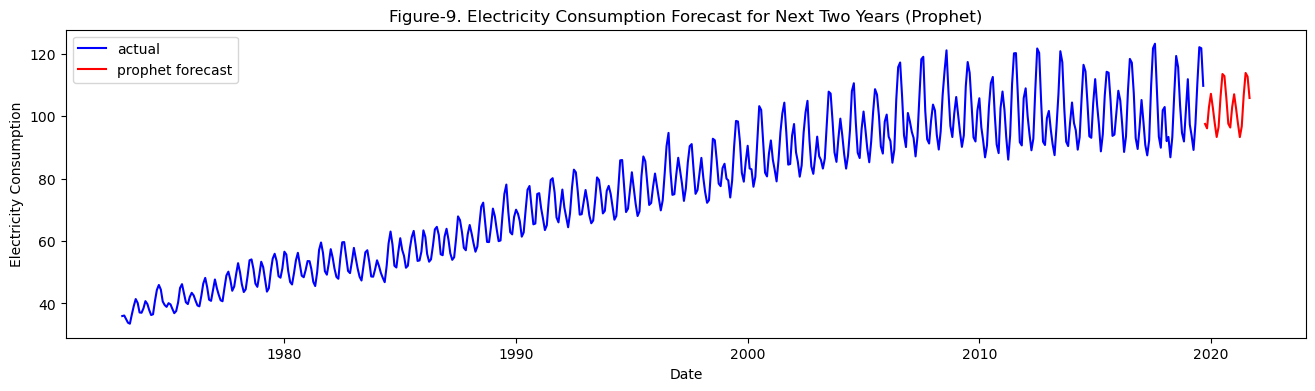

In [41]:
# Plot of the forecast with known for perspective
plt.figure(figsize=(16, 4))
sns.lineplot(x='date', y='Electricty_Consumption_in_TW', data=elec_df, color='blue', label='actual')
sns.lineplot(x='ds', y='yhat', data=forecast_assignment[-24:], color='red', label='prophet forecast')
plt.title('Figure-9. Electricity Consumption Forecast for Next Two Years (Prophet)')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.show()

In [42]:
err_df = pd.concat([errs_prophet, errs_autoARIMA, errs_SARIMAX_guess, errs_ETS], axis=0)
err_df = err_df.pivot_table(index='model', columns='metric', values='value').reset_index()
err_df = err_df[['model', 'rmse', 'rmspe', 'mape']]
err_df.to_csv("tmp/model_eval.csv", index=False)
err_df

metric,model,rmse,rmspe,mape
0,ETS,5.767906,0.059062,5.152836
1,FBProphet,5.310779,0.051901,4.525261
2,SARIMA guess,4.184353,NaN,NaN
3,auto_SARIMA,3.247649,0.032986,2.528452


# Result: SARIMA is our best bet in determining future demand. With Prophet being a close contender